# Preparing the Environment

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import json
import re

from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from typing import *

import nltk.data
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# pythorch imports
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# set the device to CPU since GPU  does not increase to much the speed when 
# using an LSTM
DEVICE = "cpu"

In [ ]:
# seed used in order to thave reproducibility
SEED = 93

# patience in the train
PATIENCE = 10

# embedding dimension
EMBEDDING_DIMENSION = 300


LR = 0.000_1
BATCH_SIZE = 512 # 512

In [ ]:
# hanlde preproducibility by setting the seed and deterministic algorithms
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [ ]:
# get the name of the file (works in colab) I sued it in order to save the 
# models (since I tried several models each with a different colab file)
from requests import get
# the below command do not work in local, but works in colab
#FILE_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
FILE_NAME = "NLP-HW1-Second-Method-Fasttext"

In [ ]:
! rm -rf sample_data

In [ ]:
# download train and dev datasets
! git clone https://github.com/SapienzaNLP/nlp2021-hw1.git

fatal: destination path 'nlp2021-hw1' already exists and is not an empty directory.


In [ ]:
# load train and dev sets
with open ("nlp2021-hw1/data/train.jsonl") as fin:
  train = []
  for line in fin:
    train.append(json.loads(line))


with open ("nlp2021-hw1/data/dev.jsonl") as fin:
  dev = []
  for line in fin:
    dev.append(json.loads(line))


In [ ]:
# see the structure of an entry of the dataset
train[0]

{'end1': '73',
 'end2': '14',
 'id': 'train.0',
 'label': 'False',
 'lemma': 'play',
 'pos': 'NOUN',
 'sentence1': 'In that context of coordination and integration, Bolivia holds a key play in any process of infrastructure development.',
 'sentence2': 'A musical play on the same subject was also staged in Kathmandu for three days.',
 'start1': '69',
 'start2': '10'}

**Visualize class distribution** in order to see if is usefull to weight the classes in the loss function

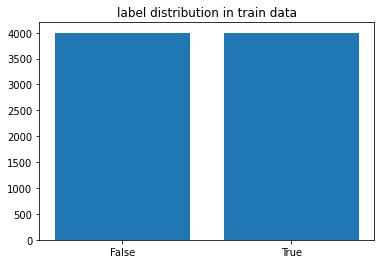

T: 4000
F: 4000



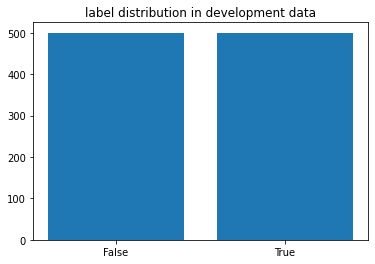

T: 500
F: 500


In [ ]:
def visualize_class_distribution(train_gold: dict, title: str):
    
    counter = Counter()

    
    for entry in train_gold:
        label = entry["label"] 
        counter[label] += 1

    labels = sorted(counter)
    values = [counter[label] for label in labels]

    plt.bar(labels, values)
    plt.title(title)
    plt.show()
    t_count = counter["True"]
    f_count = counter["False"]
    
    print(f"T: {t_count}")
    print(f"F: {f_count}")

visualize_class_distribution(train, "label distribution in train data")
print()
visualize_class_distribution(dev, "label distribution in development data")


So the classes are balanced. 
Let's see how the classes are distributed with respect to the pos tag


pos: NOUN


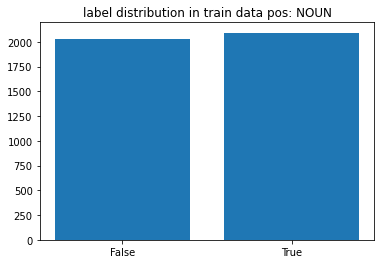

T: 2093
F: 2031

pos: ADJ


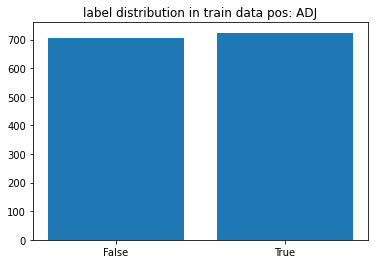

T: 724
F: 706

pos: VERB


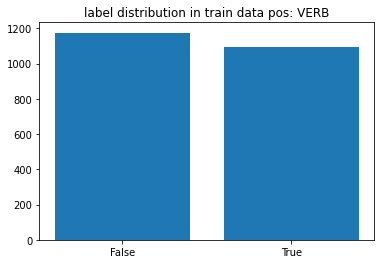

T: 1095
F: 1175

pos: ADV


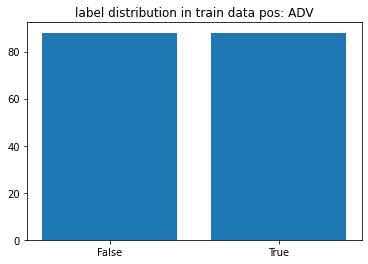

T: 88
F: 88


pos: NOUN


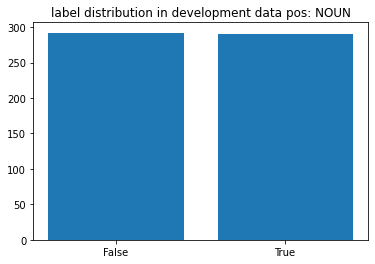

T: 290
F: 292

pos: ADJ


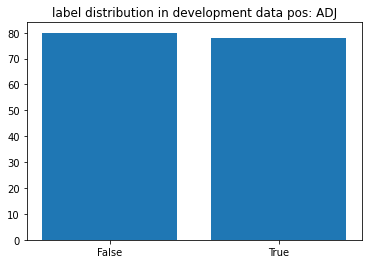

T: 78
F: 80

pos: ADV


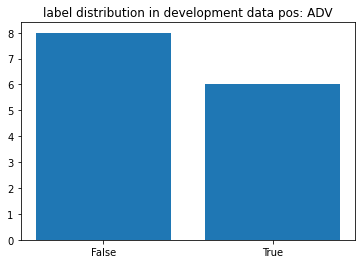

T: 6
F: 8

pos: VERB


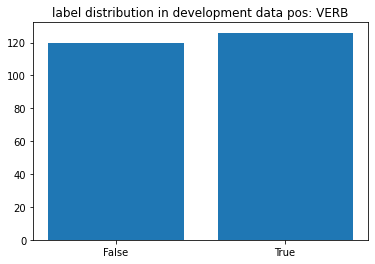

T: 126
F: 120


In [ ]:
def visualize_class_distribution_wrt_pos(train: dict, title: str):
    # dictionary containing a counter per pos
    counter = {}  
  
    for entry in train:
        label = entry["label"] 
        pos = entry["pos"]
        if (not pos in counter):
          counter[pos] = Counter()  
        counter[pos][label] += 1

    for pos in counter:
      print(f"\npos: {pos}")
      labels = sorted(counter[pos])
      values = [counter[pos][label] for label in labels]

      plt.bar(labels, values)
      plt.title(title + f" pos: {pos}")
      plt.show()
      t_count = counter[pos]["True"]
      f_count = counter[pos]["False"]
    
      print(f"T: {t_count}")
      print(f"F: {f_count}")

visualize_class_distribution_wrt_pos(train, "label distribution in train data")
print()
visualize_class_distribution_wrt_pos(dev, "label distribution in development data")

As we can see from the precedent plots the classes are almost balanced also with respect to the pos tags

In [ ]:
# download the pre trained embeddings
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2021-04-30 11:43:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  23.6MB/s    in 55s     

2021-04-30 11:44:42 (23.2 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
# unzip the embeddings
! gunzip cc.en.300.vec.gz

**Load the embedding** and check for oov terms

In [ ]:
# load the embeddings to a dictionary with key the term and value the embedding
embeddings = {}
with open(f"cc.en.{EMBEDDING_DIMENSION}.vec") as fin:
  for line in fin:
    term, *embedding = line.strip().split(" ")
    if (len(embedding) == EMBEDDING_DIMENSION):
      embedding = torch.tensor(list(map(lambda x: float(x), embedding)))  
      embeddings[term] = embedding

In [ ]:
embeddings["TARGET_TERM"] = torch.zeros(EMBEDDING_DIMENSION)

In [ ]:
# check for out of words vocabulary
def check_oovs(train:list, dev:list, embeddings:dict):
  oovs = {}
  for dataset in [(train, "train"), (dev, "dev")]:
    oovs[dataset[1]] = set()
    for entry in dataset[0]:
      s1 = entry["sentence1"]
      for term in s1.split(" "):
        if (term not in embeddings):
          oovs[dataset[1]].add(term)
      
      s2 = entry["sentence2"]
      for term in s2.split(" "):
        if (term not in embeddings):
          oovs[dataset[1]].add(term)
    # print num of oov terms
    print(len(oovs[dataset[1]]))
    # print the first oov terms
    print(list(oovs[dataset[1]])[:20])

check_oovs(train, dev, embeddings)

12269
['', 'supernovas,', 'pressure"', "he'd", 'hem,', 'chaos,', 'person,', "river's", 'sneakers,', 'stern,', 'underworld.', '(specially', 'Warriors",', 'vertebrae.', 'Algeria,', 'Up,', 'Brunel,', 'Aristaeus.', 'mode,', 'pink)']
1890
['', 'needed,', 'Cobergher', 'empire,', '"crew"', 'funding,', 'fellowship,', 'organizer,', 'glues.', 'toys,', "Wilson's", 'entourage.', 'arrests,', "Down's", 'threat,', '2004,', 'understandable,', 'workshops,', 'return,', '"Olathe".']


I have to do some preprocessing of the data in order to remove some out of vocabulary terms: 

1. remove punctuation
2. lower 

Other than this I decided to replace each target term with the string "Target_Term" that as been added to the embeddings dictionary before, in order to try to let the model understand that that term is not important for the classification since is important the context in which the target term is

In [ ]:
# preprocess a single phrase by removing punctuation and lowerize it
def preprocess_phrase(sentence:str, start:int, end:int):
  # get the original target term
  original_term = sentence[start:end].lower()
  
  # replace punctuation with space
  sentence = re.sub(r"[()\",\-—.;/:@<>#?!&$“”'’`–%\[\]−]+", " ", sentence) 
  # remove extra space
  sentence = re.sub(r"\s+", " ", sentence)
  sentence = sentence.replace("'s", " 's")
  # strip and lowerize the obtained sentence
  sentence = sentence.strip().lower()
  
  sentence = " ".join(word_tokenize(sentence))

  sentence = sentence.replace(original_term, "TARGET_TERM")

  # get the new position of the target term
  start_n = sentence.find("TARGET_TERM")
  end_n = start_n + len("TARGET_TERM")

  # check that the position is correct
  assert "TARGET_TERM" == sentence[start_n:end_n] 

  return sentence, start_n, end_n

def preprocessing(entries: List[Dict])-> List[Dict]:
  preprocessed = []
  for entry in entries:
    
    # get preprocessed phrase and the position of the target term
    sentence1, start1, end1 = preprocess_phrase(entry["sentence1"], int(entry["start1"]), int(entry["end1"]))
    sentence2, start2, end2 = preprocess_phrase(entry["sentence2"], int(entry["start2"]), int(entry["end2"]))
    
    # copy the entry and replace senteces and positions of the target terms
    # in both the phrases
    preprocessed_entry = entry.copy()
    preprocessed_entry["sentence1"] = sentence1
    preprocessed_entry["sentence2"] = sentence2
    preprocessed_entry["start1"] = start1
    preprocessed_entry["end1"] = end1
    preprocessed_entry["start2"] = start2
    preprocessed_entry["end2"] = end2
    
    preprocessed.append(preprocessed_entry)

  return preprocessed


train_n, dev_n = preprocessing(train), preprocessing(dev)

check_oovs(train_n, dev_n, embeddings)

2109
['kessenich', 'aaiún', 'capua', 'pasolini', 'ryb', 'ariabignes', 'blauser', 'nuphar', 'eglon', 'awami', 'shahu', 'hideki', 'livesay', 'uxo', 'savre', 'interpal', 'unfpa', 'durvinita', 'hinamori', 'carapintada']
200
['lachin', 'stalinization', 'bufang', 'mindtouch', 'ledra', 'r249', 'ppar', 'gilfoyle', 'kangin', 'intelsat', 'madhar', 'iprs', 'warwicks', 'taavel', 'nuciferine', 'starkwedder', 'huallaga', 'unhcr', 'nojima', 'bhattacharyya']


As we can see from the precedent part we have removed a lot of oovs by removing punctuation and applying lower() to the entire phrase

In [ ]:
class PhraseDataset(Dataset):

    def __init__(self, dataset: list, feature_extraction_function: Callable[[str], torch.tensor], word_index: dict):
        
        self.word_index = word_index
        self.dataset = dataset
        self.feature_extraction_function = feature_extraction_function
        # initialize the data
        self.__init_data()


    def __init_data(self):
        self.samples = []
        for entry in self.dataset:
          # for each entry in the dataset get the target term
          term_1 = entry["sentence1"][entry["start1"]: entry["end1"]]
          term_2 = entry["sentence2"][entry["start2"]: entry["end2"]]

          # get the indexes of the phrases
          indexes1 = self.feature_extraction_function(entry["sentence1"], self.word_index)
          indexes2 = self.feature_extraction_function(entry["sentence2"], self.word_index)
          
          # get the target term position
          term_1_index = entry["sentence1"].split(" ").index(term_1)
          term_2_index = entry["sentence2"].split(" ").index(term_2)

          # build the data sample as a tuple containing 
          # 1) a tuple with the list of indexes of the terms relative to the phrases (in order)
          # 2) the target term position of the two phrases
          # 3) the label
          data = ((indexes1, indexes2), (term_1_index, term_2_index), float(1) if entry["label"] == "True" else float(0))

          # append the sample
          self.samples.append(data)
          
    def __len__(self):
        # returns the number of samples in our dataset
      return len(self.samples)

    def __getitem__(self, idx):
        # returns the idx-th sample
        return self.samples[idx]

In [ ]:
# word dict associates each term to a index inside the vectors_store
word_index = dict()
# vectors_store is a list containing in position i the emebdding of the term 
# relative to position i. in position 0 we have the pad token and in position 1
# we have the unk token
vectors_store = []

# pad token, index = 0
vectors_store.append(torch.zeros(300))

# unk token, index = 1
vectors_store.append(torch.rand(300))

for word, vector in embeddings.items():
    word_index[word] = len(vectors_store)
    vectors_store.append(vector)

word_index = defaultdict(lambda: 1, word_index)  # default dict returns 1 (unk token) when unknown word
vectors_store = torch.stack(vectors_store)

In [ ]:
# associates a phrase to the sequence of indeces relative to the terms inside the phrase
def phrase2indices(review: str, word_index: Dict) -> torch.Tensor:
    return torch.tensor([word_index[word] for word in review.split(" ")], dtype=torch.long)

In [ ]:
# create the Dataset objects for train and dev datasets
train_dataset = PhraseDataset(train_n, phrase2indices, word_index)
dev_dataset = PhraseDataset(dev_n, phrase2indices, word_index)

In [ ]:

# given a list of sentences (each a tensor of indexes of term) return a tuple containing
#  1) the padded sequences of indeces
#  2) the sentences lenghts
def single_collate_fn(sentences: List[torch.Tensor])-> Tuple[torch.Tensor, torch.Tensor]:

  sentence_lengths = torch.tensor([sentence.size(0)-1 for sentence in sentences], dtype=torch.long)
  sentences = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0) 

  return sentences, sentence_lengths
# given a list of tuple containing
# 1) a tuple of
#   1.1) a tuple containing the indexes (in vectors_store) of the terms in the sentences
#   1.2) the target term position
#   1.3) the label
# and returns 
# 1) a tuple containing the sequences of indexes of terms (in vector_store) for the two sentences
# 2) a tuple containing the lenghts of the two sentences
# 3) a tuple containing the target term positio in the sentence
# 4) the label
def collate_fn(
    entries: List[Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[int, int], float]]
) -> Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:

    sentences1 = [entry[0][0] for entry in entries]
    sentences2 = [entry[0][1] for entry in entries]
    
    # get the padded sentences and the lenght of the sentences
    sentences1, sentence_lengths1 = single_collate_fn(sentences1)
    sentences2, sentence_lengths2 = single_collate_fn(sentences2)

    #get target term position in the sentences
    target_term_indexes1 = torch.tensor([entry[1][0] for entry in entries])
    target_term_indexes2 = torch.tensor([entry[1][1] for entry in entries])

    # get lables
    y = [entry[-1] for entry in entries]
    y = torch.tensor(y)

    return (sentences1, sentences2), (sentence_lengths1, sentence_lengths2), (target_term_indexes1, target_term_indexes2), y

In [ ]:
# create the dataloader objects for train and test with batch size to BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# see the structure of a sample from the dataloader
for batch in train_dataloader:
    #sentences, target_term_indexes, y = batch
    sentences, sentence_lengths, target_term_indexes, y = batch
    
    print(f"# batch len: {len(batch)}\n")
    print(f"# batch sentences shape: {sentences[0].shape}, {sentences[1].shape}\n")
    print(f"# batch sentence_lengths shape: {sentence_lengths[0].shape}, {sentence_lengths[1].shape}\n")
    print(f"# batch target_term_indexes shape: {target_term_indexes[0].shape}, {target_term_indexes[1].shape}\n")

    print(f"# batch y shape: {y.shape}\n")
    break

# batch len: 4

# batch sentences shape: torch.Size([512, 69]), torch.Size([512, 77])

# batch sentence_lengths shape: torch.Size([512]), torch.Size([512])

# batch target_term_indexes shape: torch.Size([512]), torch.Size([512])

# batch y shape: torch.Size([512])



# Train

In [ ]:
# method to save the model 
def save_model(model: nn.Module, path:str):
  torch.save(model.state_dict(), path)

In [ ]:
# method to train and evaluate
def train_and_evaluate(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    epochs: int = 50,
    dev_dataloader: DataLoader = None,
    dev_fn: Callable = None,
    verbose: bool = True,
):
    # history
    train_loss = []
    dev_losses = []
    dev_accs = []
    train_accs = []

    # current value of patience
    patience = 0
    for epoch in range(epochs):
        # put the model in train mode so that we activate the dropout
        model.train()
        # store the losses and the accs over the several batches in this epoch
        losses = []
        accs = []

        # for each batch
        for batch in train_dataloader:
            # reset the gradient of the optimizer
            optimizer.zero_grad()
            
            sentences, sentence_lengths, target_term_indexes, y = batch
            
            # move data to device
            y = y.to(DEVICE)
            sentences1, sentences2 = [x.to(DEVICE) for x in sentences]
            sentence_lengths1, sentence_lengths2 = [x.to(DEVICE) for x in sentence_lengths]
            target_term_indexes1, target_term_indexes2 = [x.to(DEVICE) for x in target_term_indexes]


            # batch_out is a dictionary with loss and acc keys
            batch_out = model(sentences1, sentences2, sentence_lengths1, sentence_lengths2, target_term_indexes1, target_term_indexes2, y)
            
            loss = batch_out["loss"]
            acc = batch_out["acc"]
            # store the acc and the loss
            losses.append(loss)
            accs.append(acc)

            # computes the gradient of the loss
            loss.backward()
          
            # updates parameters based on the gradient information
            optimizer.step()

        model.global_epoch += 1
        # mean loss and acc in the epoch
        mean_loss = sum(losses) / len(losses)
        mean_acc = sum(accs) / len(accs)
        
        # store the mean loss and acc
        train_loss.append(mean_loss.item())
        train_accs.append(mean_acc.item())
        
        if verbose or epoch == epochs - 1:
            print(f"\tEpoch\t{model.global_epoch:3d} => Loss: {mean_loss:0.6f}")
        
        if dev_dataloader and dev_fn is not None:
            
            # put the model in evaluating mode
            model.eval()
            # evaluate the model over the development set
            dev_output = dev_fn(model, dev_dataloader)
            # get acc and loss
            dev_loss_value = dev_output["loss"]
            dev_acc_value = dev_output["acc"]
            # if the loss is higher than the minimun dev loss stored, increase 
            # patience level, otherwise reset it 
            if (len(dev_losses) > 0 and dev_loss_value > min(dev_losses)):
              patience += 1
            else:
              # save the best model (it will be overwritten when I arrive to a 
              # lower loss value
              if (epoch > 40):
                save_model(model, f"{FILE_NAME}.pt")
              patience = 0
            
            # save dev loss and acc
            dev_losses.append(dev_loss_value)
            dev_accs.append(dev_acc_value)

            # info prints
            print(f"\t\tDevelopment => Loss: {dev_loss_value:0.6f}")
            print(f"\t\tDevelopment => Acc: {dev_acc_value:0.6f}")
            print()

            # early stopping
            if (patience > PATIENCE):
              print("EARLY STOPPING")
              break 
    print(f"max_dev_acc: {max(dev_accs)}")
    return {"train": train_loss, "dev":dev_losses, "dev_accs":dev_accs, "train_accs": train_accs}

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self,
                 n_hidden1: int,
                 n_hidden2: int,                 
                 dropout:float,
                 vectors_store: torch.Tensor,
                 device: str):
        super().__init__()
        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(vectors_store)
        self.n_hidden1 = n_hidden1
        # recurrent layer
        self.rnn = torch.nn.LSTM(input_size=EMBEDDING_DIMENSION, hidden_size=n_hidden1, num_layers=2, batch_first=True, bidirectional=True, dropout=dropout)

        self.bn1 = torch.nn.BatchNorm1d(num_features = n_hidden1*4+3)
        self.bn2 = torch.nn.BatchNorm1d(num_features = n_hidden2)

        # dropout
        self.drop = torch.nn.Dropout(dropout)

        # classification head
        # *4 since -> *2 cause of the concatenation 
        #          -> *2 cause of the bidirectional LSTM
        self.lin1 = torch.nn.Linear(n_hidden1*4+3, n_hidden2)
        self.lin2 = torch.nn.Linear(n_hidden2, 1)

        self.loss_fn = torch.nn.BCELoss()
        self.global_epoch = 0

        # cosine similarity function
        self.cos = cos = nn.CosineSimilarity(dim=1, eps=1e-6)

        self.device = device
    
    def forward(
        self, 
        sentences1: torch.Tensor,  
        sentences2: torch.Tensor,  
        sentence_lengths1: torch.Tensor, 
        sentence_lengths2: torch.Tensor, 
        target_term_indexes1: torch.Tensor, 
        target_term_indexes2: torch.Tensor, 
        y: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        
        # embedding words from indices
        embeddings1 = self.embedding(sentences1)
        embeddings2 = self.embedding(sentences2)

        # recurrent encoding
        recurrent_out1 = self.rnn(embeddings1)
        
        # get the output per term in the paddes sentence        
        recurrent_out1 = recurrent_out1[0]

        # get the target term backward and forward output
        target_term_vectors1 = recurrent_out1[range(recurrent_out1.shape[0]), target_term_indexes1]
        # get the first term backward output
        start_sentence_vectors1 = recurrent_out1[range(recurrent_out1.shape[0]), [0]*len(sentence_lengths1), self.n_hidden1:]
        # get the last term forward output
        end_sentence_vectors1 = recurrent_out1[range(recurrent_out1.shape[0]), sentence_lengths1, :self.n_hidden1]

        # recurrent encoding for the second sentence
        recurrent_out2 = self.rnn(embeddings2)

        # get the output per term in the paddes sentence        
        recurrent_out2 = recurrent_out2[0]
        
        # get the target term backward and forward output
        target_term_vectors2 = recurrent_out2[range(recurrent_out2.shape[0]), target_term_indexes2]
        # get the first term backward output
        start_sentence_vectors2 = recurrent_out2[range(recurrent_out2.shape[0]), [0]*len(sentence_lengths2), self.n_hidden1:]
        # get the last term forward output
        end_sentence_vectors2 = recurrent_out2[range(recurrent_out2.shape[0]), sentence_lengths2, :self.n_hidden1]
        
        # save memory
        recurrent_out2 = None

        # compute cosine similarity
        cos_target = torch.unsqueeze(self.cos(target_term_vectors1, target_term_vectors2),1)
        cos_start_sentence = torch.unsqueeze(self.cos(start_sentence_vectors1, start_sentence_vectors2),1)
        cos_end_sentence = torch.unsqueeze(self.cos(end_sentence_vectors1, end_sentence_vectors2),1)
        
        # concatenate values
        summary_vectors = torch.hstack((
                                        torch.abs(target_term_vectors1-target_term_vectors2),
                                        torch.abs(start_sentence_vectors1-start_sentence_vectors2),
                                        torch.abs(end_sentence_vectors1-end_sentence_vectors2),
                                        cos_target, 
                                        cos_start_sentence, 
                                        cos_end_sentence))
        # dropout
        summary_vectors = self.drop(summary_vectors)
        
        # two fc layers
        out = self.lin1(summary_vectors)
        out = torch.relu(out)
        out = self.bn2(out)
        out = self.lin2(out).squeeze(1)

        logits = out
        pred = torch.sigmoid(logits)

        result = {'logits': logits, 'pred': pred}

        # compute loss
        if y is not None:
            loss = self.loss(pred, y)
            result["loss"] = loss
            result["acc"] = (torch.round(pred) == y).float().sum()/len(y)
            # number of correct predictions
            result["correct"] = (torch.round(pred) == y).float().sum()

        return result
    def loss(self, pred, y):
        return self.loss_fn(pred, y)


In [ ]:
@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
):
    losses = []
    accs = []
    size = 0
    for batch in dataloader:
        # unpack
        sentences, sentence_lengths, target_term_indexes, y = batch

        # move data to device
        y = y.to(DEVICE)
        sentences1, sentences2 = [x.to(DEVICE) for x in sentences]
        sentence_lengths1, sentence_lengths2 = [x.to(DEVICE) for x in sentence_lengths]
        target_term_indexes1, target_term_indexes2 = [x.to(DEVICE) for x in target_term_indexes]

        outputs = model(sentences1, sentences2, sentence_lengths1, sentence_lengths2, target_term_indexes1, target_term_indexes2, y)

        # get the number of elements in the batch (it is not constant since the 
        # number of examples is not a multiple of BATCH_SIZE, so the last batch
        # will be smaller)
        size += len(y)

        # get loss and acc
        loss = outputs["loss"]
        losses.append(loss*len(y))
        # append the number of correct predictions
        accs.append(outputs["correct"])

    # get mean acc and mean loss
    mean_acc = sum(accs)/size
    mean_loss = sum(losses) / size
    return {
        "loss": mean_loss,
        "acc": mean_acc,
    }

In [ ]:
# preproducibility
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

model = Classifier(n_hidden1=128, n_hidden2=32, dropout=0.5, vectors_store=vectors_store, device=DEVICE)
model.to(DEVICE)
# define the adam optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scores = train_and_evaluate(model, optimizer, train_dataloader, epochs=2_000, dev_dataloader=dev_dataloader, dev_fn=evaluate)

	Epoch	  1 => Loss: 0.738967
		Development => Loss: 0.693496
		Development => Acc: 0.500000

	Epoch	  2 => Loss: 0.716852
		Development => Loss: 0.693098
		Development => Acc: 0.500000

	Epoch	  3 => Loss: 0.709581
		Development => Loss: 0.692266
		Development => Acc: 0.507000

	Epoch	  4 => Loss: 0.701023
		Development => Loss: 0.690783
		Development => Acc: 0.514000

	Epoch	  5 => Loss: 0.700117
		Development => Loss: 0.688755
		Development => Acc: 0.546000

	Epoch	  6 => Loss: 0.697164
		Development => Loss: 0.687254
		Development => Acc: 0.561000

	Epoch	  7 => Loss: 0.694025
		Development => Loss: 0.686516
		Development => Acc: 0.564000

	Epoch	  8 => Loss: 0.694060
		Development => Loss: 0.685774
		Development => Acc: 0.562000

	Epoch	  9 => Loss: 0.694395
		Development => Loss: 0.685157
		Development => Acc: 0.563000

	Epoch	 10 => Loss: 0.691911
		Development => Loss: 0.684658
		Development => Acc: 0.563000

	Epoch	 11 => Loss: 0.690318
		Development => Loss: 0.683964
		Develop

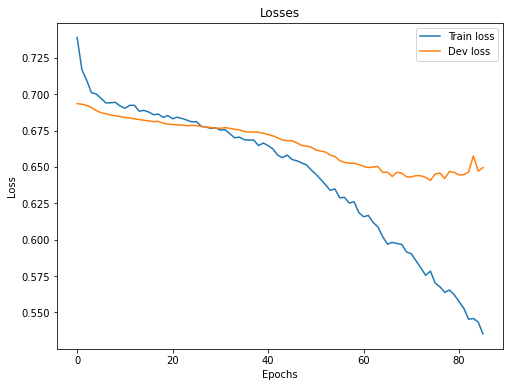

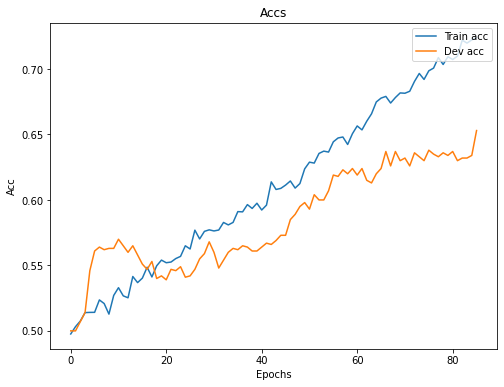

In [ ]:
def plot_logs(logs: dict):
    
    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(logs['train']))), logs['train'], label='Train loss')
    plt.plot(list(range(len(logs['dev']))), logs['dev'], label='Dev loss')
    
    plt.title("Losses")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot(list(range(len(logs['train_accs']))), logs['train_accs'], label='Train acc')
    plt.plot(list(range(len(logs['dev_accs']))), logs['dev_accs'], label='Dev acc')
    
    plt.title("Accs")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(loc="upper right")

    plt.show()

plot_logs(scores)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def plots(
    model: nn.Module,
    dataloader: DataLoader,
):
    accs = []
    preds = torch.tensor([])
    gt = torch.tensor([])
    size = 0
    for batch in dataloader:

        sentences, sentence_lengths, target_term_indexes, y = batch

        y = y.to(DEVICE)
        sentences1, sentences2 = [x.to(DEVICE) for x in sentences]
        sentence_lengths1, sentence_lengths2 = [x.to(DEVICE) for x in sentence_lengths]
        target_term_indexes1, target_term_indexes2 = [x.to(DEVICE) for x in target_term_indexes]


        outputs = model(sentences1, sentences2, sentence_lengths1, sentence_lengths2, target_term_indexes1, target_term_indexes2, y)

        # get the number of elements in the batch (it is not constant since the 
        # number of examples is not a multiple of BATCH_SIZE, so the last batch
        # will be smaller)
        size += len(y)
        preds = torch.hstack((preds, outputs["pred"]))
        gt = torch.hstack((gt, y))
        accs.append(outputs["correct"])

    # get mean acc and mean loss
    mean_acc = sum(accs)/size
    
    # confusion matrix
    classes = ["True", "False"]
    cf_matrix = confusion_matrix(gt.cpu().numpy(), torch.round(preds).cpu().numpy())
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.savefig('output.png')
    plt.show()

    print()

    # roc curve and score
    roc_score = roc_auc_score(gt.cpu().numpy(), preds.cpu().numpy())
    fpr, tpr, _ = roc_curve(gt.cpu().numpy(), preds.cpu().numpy())

    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.', label='ROC AUC=%.3f' % (roc_score))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()

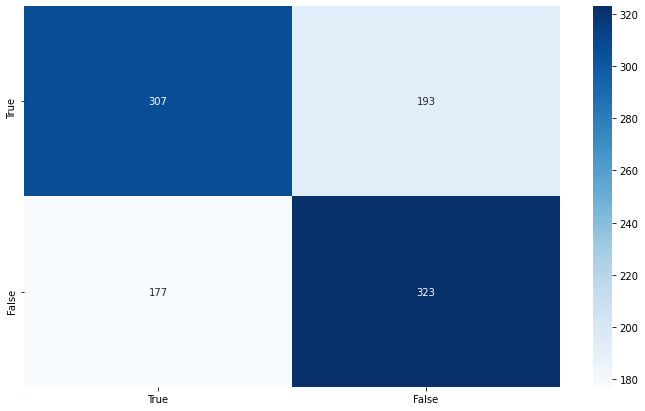

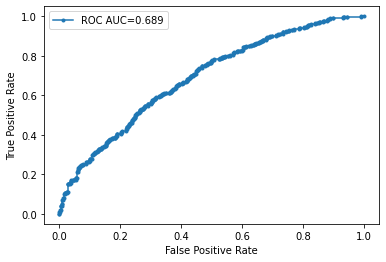

In [ ]:
model = Classifier(n_hidden1=128, n_hidden2=32, dropout=0.5, vectors_store=vectors_store, device=DEVICE)
model.load_state_dict(torch.load(f"{FILE_NAME}.pt"))
model.eval()

plots(model, dev_dataloader)